# 1. EDA for data from MyAnimeList

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import spacy

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from wordcloud import WordCloud


pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', None)

%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aligator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [2]:
maldf = pd.read_csv('../datasets/dataset_full.csv', encoding = 'utf-8')

In [3]:
maldf.head()

,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,...,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist, Fullmetal Alchemist (2009), FMA, FMAB",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,...,['Fullmetal Alchemist: Brotherhood - 4-Koma Theater'],"""In order for something to be obtained, something of equal value must be lost.""\n\nAlchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist.\n\nThree years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity.\n\n[Written by MAL Rewrite]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_no_Kyojin__The_Final_Season,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan Season 4",進撃の巨人 The Final Season,TV,16.0,Currently Airing,...,NaN,"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. \n\nHaving finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls.\n\nIn Shingeki no Kyojin: The Final Season, two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom.\n\n[Written by MAL Rewrite]",['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,...,NaN,"The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel.\n\nThough miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysteriou

In [4]:
maldf['Title'].nunique()

17476

In [5]:
#check number of nulls in score column

print (f"The number of missing values in Score Column is: {maldf['Score'].isnull().sum():.0f}")


print (f"The number of values in Score Column is: {maldf['Score'].notnull().sum():.0f}")


The number of missing values in Score Column is: 5125
The number of values in Score Column is: 12364


In [6]:
maldf['Genres'].dtype

dtype('O')

In [7]:
#string split the values in the genres column into multiple columns with 'Genre_' as prefix
maldf2 = maldf.join(maldf['Genres'].str.split(',',expand=True).add_prefix('Genre_').fillna(np.nan))
 


In [8]:
maldf2.head()

,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,...,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist, Fullmetal Alchemist (2009), FMA, FMAB",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,...,'Comedy','Drama','Magic','Fantasy','Shounen'],NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_no_Kyojin__The_Final_Season,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan Season 4",進撃の巨人 The Final Season,TV,16.0,Currently Airing,...,'Super Power','Drama','Fantasy','Shounen'],NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_no_Kyojin_Season_3_Part_2,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,...,'Super Power','Drama','Fantasy','Shounen'],NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,...,'Parody','Samurai','Sci-Fi','Shounen'],NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
maldf2['Title'].nunique()

17476

## 1.1 Explore Genre Data

In [10]:
#select all the genre columns
genre_col = [col for col in maldf2 if col.startswith('Genre_')]
genre_col

['Genre_0',
 'Genre_1',
 'Genre_2',
 'Genre_3',
 'Genre_4',
 'Genre_5',
 'Genre_6',
 'Genre_7',
 'Genre_8',
 'Genre_9',
 'Genre_10',
 'Genre_11',
 'Genre_12']

In [11]:
#remove punctuation in selected genre columns
#maldf2[genre_col] = maldf2[genre_col].replace(r'[^\w\s]', '', regex=True)

#create a list of punctuation to remove
punctuation = ["\[", "\]" ,"\'"] 


for i in punctuation:
    maldf2[genre_col] = maldf2[genre_col].replace(i,"", regex=True)


In [12]:
maldf2.head()

,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,...,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist, Fullmetal Alchemist (2009), FMA, FMAB",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,...,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_no_Kyojin__The_Final_Season,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan Season 4",進撃の巨人 The Final Season,TV,16.0,Currently Airing,...,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_no_Kyojin_Season_3_Part_2,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,...,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,...,Parody,Samurai,Sci-Fi,Shounen,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#strip values in genre cols of whitespace
maldf2[genre_col] = maldf2[genre_col].apply(lambda x: x.str.strip())

In [14]:
#unpivot from genre values from wide to long using melt
genscore = maldf2.filter(regex=r'Score|Genre_').melt('Score', value_name='Genre')


In [15]:
#use a dictionary for groupby

genscore_dict = {'Value_Count': ('Genre', 'count'), 'Average_Score': ('Score', 'mean')}
genscore_df = genscore.groupby('Genre', as_index=False).agg(**genscore_dict)
genscore_df

,Genre,Value_Count,Average_Score
0,Action,3865,6.754483
1,Adventure,2950,6.758087
2,Cars,132,6.532154
3,Comedy,6009,6.708433
4,Dementia,510,5.256141
5,Demons,494,6.730165
6,Drama,2616,6.981444
7,Ecchi,768,6.488529
8,Fantasy,3258,6.679902
9,Game,385,6.581900


In [16]:
#get top 10 based on count and average score
genscore_top10 = genscore_df.sort_values(['Value_Count','Average_Score'], ascending=False).head(10)

genscore_top10

,Genre,Value_Count,Average_Score
3,Comedy,6009,6.708433
0,Action,3865,6.754483
8,Fantasy,3258,6.679902
1,Adventure,2950,6.758087
15,Kids,2662,6.254003
6,Drama,2616,6.981444
29,Sci-Fi,2575,6.645504
20,Music,2230,6.099484
33,Shounen,1995,7.039966
35,Slice of Life,1898,6.844809


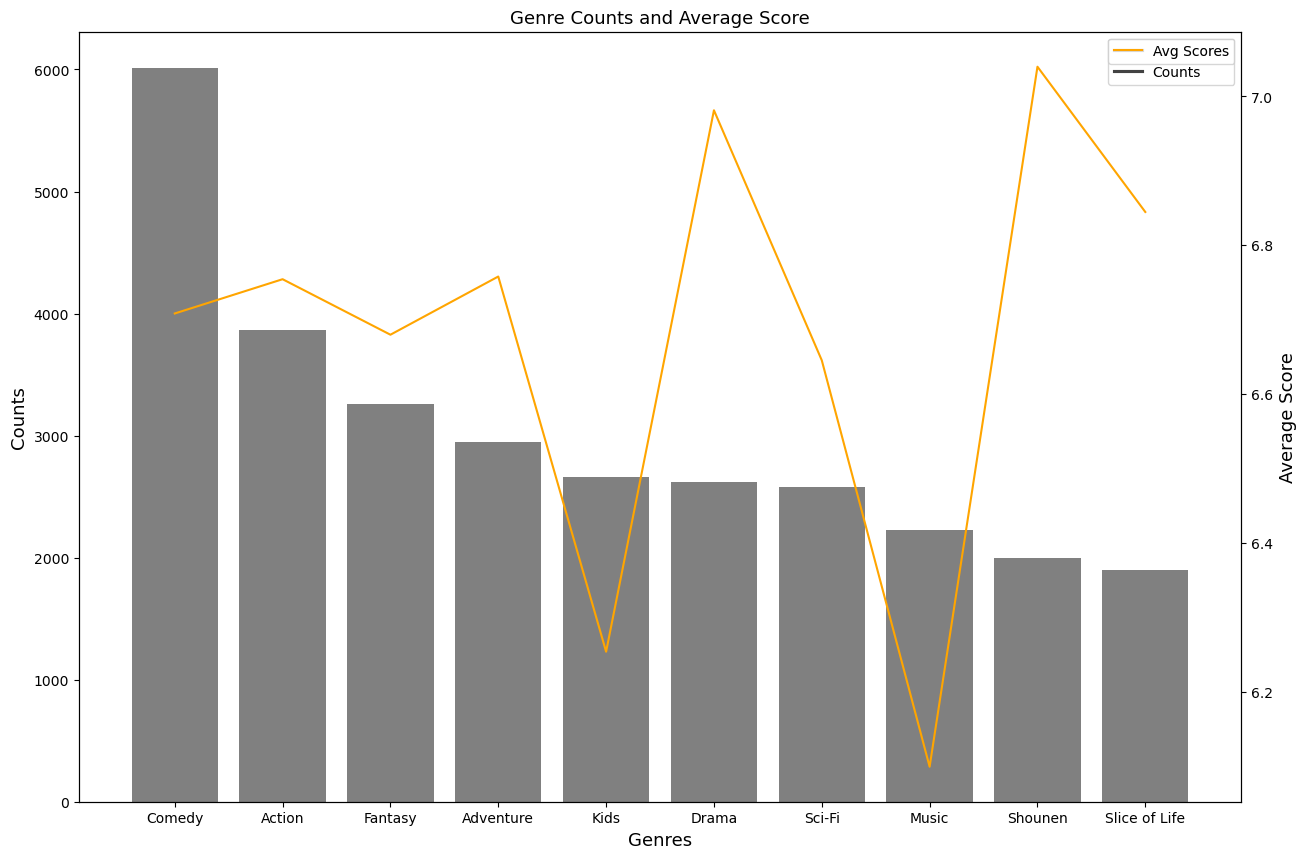

In [17]:
#plot the rating counts


fig, ax1 = plt.subplots(figsize=(15,10))

#bar plot creation
ax1.set_title('Genre Counts and Average Score', fontsize = 13)
ax1 = sns.barplot(x='Genre',y='Value_Count', data = genscore_top10, color='grey', label = 'Counts')
ax1.set_xlabel('Genres', fontsize = 13)
ax1.set_ylabel('Counts', fontsize = 13)
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
#line plot creation
ax2 = sns.lineplot(x= 'Genre', y='Average_Score', data=genscore_top10, color = 'orange', label = 'Avg Scores')
ax2.set_ylabel('Average Score', fontsize = 13)

ax2.tick_params(axis='y')

ax1.legend(loc='upper right', labels=['Avg Scores','Counts'])
plt.show()


#plt.tight_layout();

In [18]:
#plotting genres with threshold
genre_threshold = 500
genscore_df['Cross_Threshold'] = (genscore_df['Value_Count'] > genre_threshold)

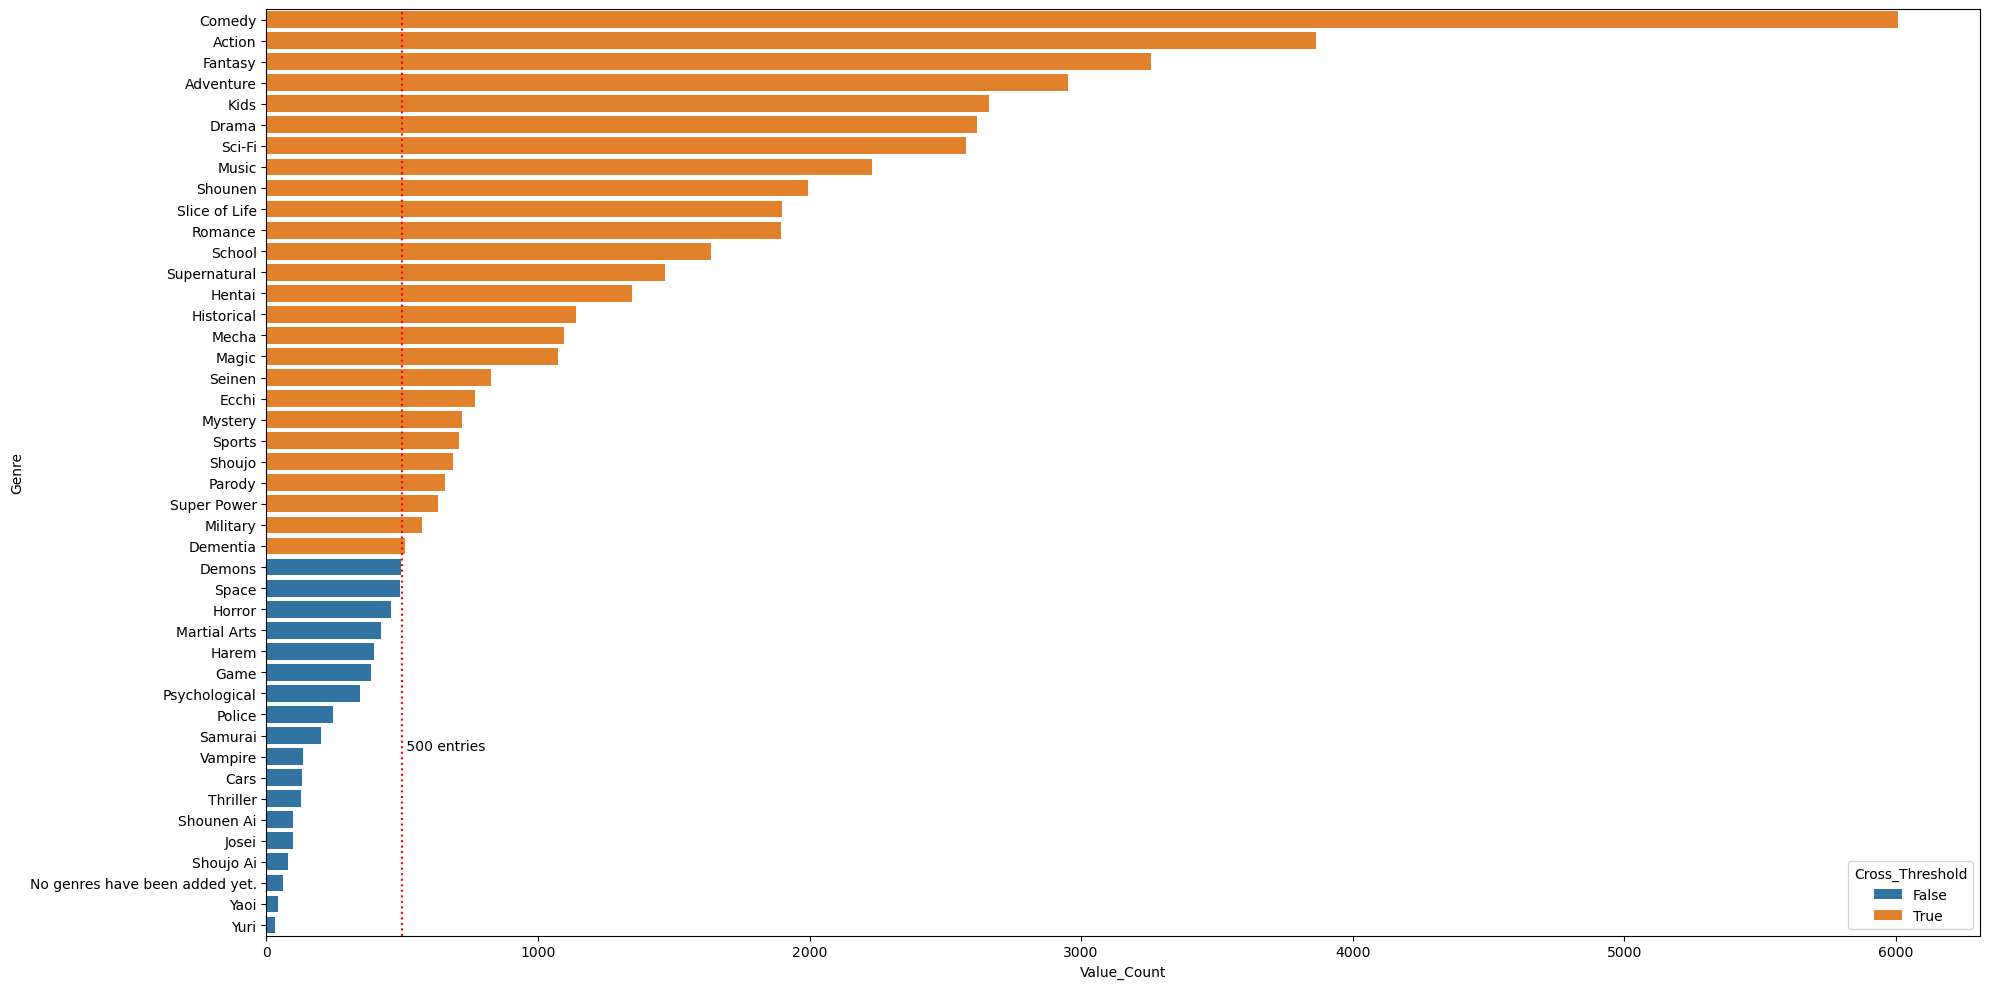

In [19]:
#plot the genre counts
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=genscore_df.sort_values('Value_Count', ascending=False), y='Genre', x='Value_Count', hue='Cross_Threshold', ax=ax)
plt.axvline(genre_threshold, color='red', linestyle=':')
plt.text(genre_threshold, 0.2, " " + str(genre_threshold) + " entries", transform=ax.get_xaxis_transform())
plt.tight_layout();

## 1.2 Explore ratings data

In [20]:
#get rating counts

rating_counts = maldf2['Rating'].value_counts().rename_axis('Rating').reset_index(name='Count')



## rating_counts

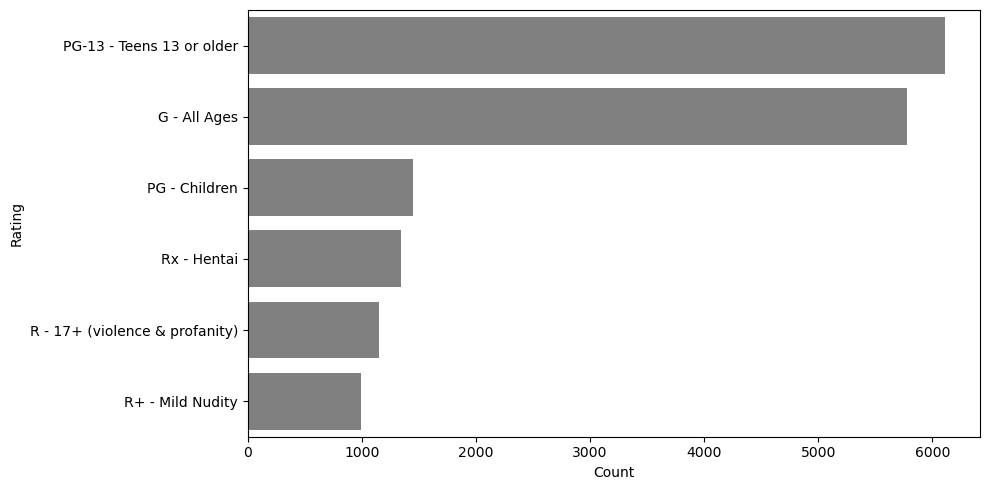

In [21]:
#plot the rating counts
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=rating_counts.sort_values('Count', ascending=False), y='Rating', x='Count', color='grey', ax=ax)
plt.tight_layout();

## 1.3 Explore producer data

In [22]:
#string split the values in the producers column into multiple columns with 'Producer_' as prefix
maldf3 = maldf2.join(maldf2['Producers'].str.split(',',expand=True).add_prefix('Producer_').fillna(np.nan))

In [23]:
#select all the producer columns
prod_col = [col for col in maldf3 if col.startswith('Producer_')]
prod_col

['Producer_0',
 'Producer_1',
 'Producer_2',
 'Producer_3',
 'Producer_4',
 'Producer_5',
 'Producer_6',
 'Producer_7',
 'Producer_8',
 'Producer_9',
 'Producer_10',
 'Producer_11',
 'Producer_12',
 'Producer_13',
 'Producer_14',
 'Producer_15',
 'Producer_16',
 'Producer_17',
 'Producer_18',
 'Producer_19']

In [24]:
maldf3.head(100)

,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,...,Producer_10,Producer_11,Producer_12,Producer_13,Producer_14,Producer_15,Producer_16,Producer_17,Producer_18,Producer_19
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist, Fullmetal Alchemist (2009), FMA, FMAB",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_no_Kyojin__The_Final_Season,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan Season 4",進撃の巨人 The Final Season,TV,16.0,Currently Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_no_Kyojin_Season_3_Part_2,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5,Hunter x Hunter (2011),https://myanimelist.net/anime/11061/Hunter_x_Hunter_2011,Hunter x Hunter,HxH (2011),HUNTER×HUNTER（ハンター×ハンター）,TV,148.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,6,Gintama',https://myanimelist.net/anime/9969/Gintama,Gintama Season 2,Gintama (2011),銀魂',TV,51.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,7,Ginga Eiyuu Densetsu,https://myanimelist.net/anime/820/Ginga_Eiyuu_Densetsu,Legend of the Galactic Heroes,"LoGH, LotGH, Gin'eiden, GinEiDen, Heldensagen Vom Kosmosinsel",銀河英雄伝説,OVA,110.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,8,Gintama': Enchousen,https://myanimelist.net/anime/15417/Gintama__Enchousen,Gintama: Enchousen,"Gintama' (2012), Gintama' Overdrive, Kintama",銀魂' 延長戦,TV,13.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,9,3-gatsu no Lion 2nd Season,https://myanimelist.net/anime/35180/3-gatsu_no_Lion_2nd_Season,March Comes In Like A Lion 2nd Season,Sangatsu no Lion Second Season,3月のライオン 第2シリーズ,TV,22.0,Finished Airing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#create a list of punctuation to remove
punctuation = ["\[", "\]" ,"\'", '\"'] 


for i in punctuation:
    maldf3[prod_col] = maldf3[prod_col].replace(i,"", regex=True)



In [26]:
#strip values in genre cols of whitespace
maldf3[prod_col] = maldf3[prod_col].apply(lambda x: x.str.strip())

In [27]:
#unpivot from genre values from wide to long using melt
prodscore = maldf3.filter(regex=r'Score|Producer_').melt('Score', value_name='Producer')


In [28]:
#use a dictionary for groupby

prodscore_dict = {'Value_Count': ('Producer', 'count'), 'Average_Score': ('Score', 'mean')}
prodscore_df = prodscore.groupby('Producer', as_index=False).agg(**prodscore_dict)
prodscore_df

,Producer,Value_Count,Average_Score
0,,7761,6.267421
1,12 Diary Holders,1,7.560000
2,1st PLACE,1,7.080000
3,1theK,2,NaN
4,3xCube,1,7.190000
...,...,...,...
1300,project lights,1,5.460000
1301,studioGONG,1,6.920000
1302,syn Sophia,1,6.560000
1303,teamKG,1,5.820000


In [29]:
prodscore_df['Producer'].nunique()

1305

In [30]:
#sort values by average score
prodscore_top10 = prodscore_df.sort_values(['Value_Count','Average_Score'], ascending=False).head(10)

prodscore_top10

,Producer,Value_Count,Average_Score
0,,7761,6.267421
713,NHK,715,6.374250
82,Aniplex,492,7.409958
1100,TV Tokyo,476,7.041193
606,Lantis,443,7.016697
150,Bandai Visual,416,7.019975
371,Fuji TV,332,7.157500
699,Movic,324,7.170062
827,Pony Canyon,315,6.967153
978,Sotsu,302,6.980692


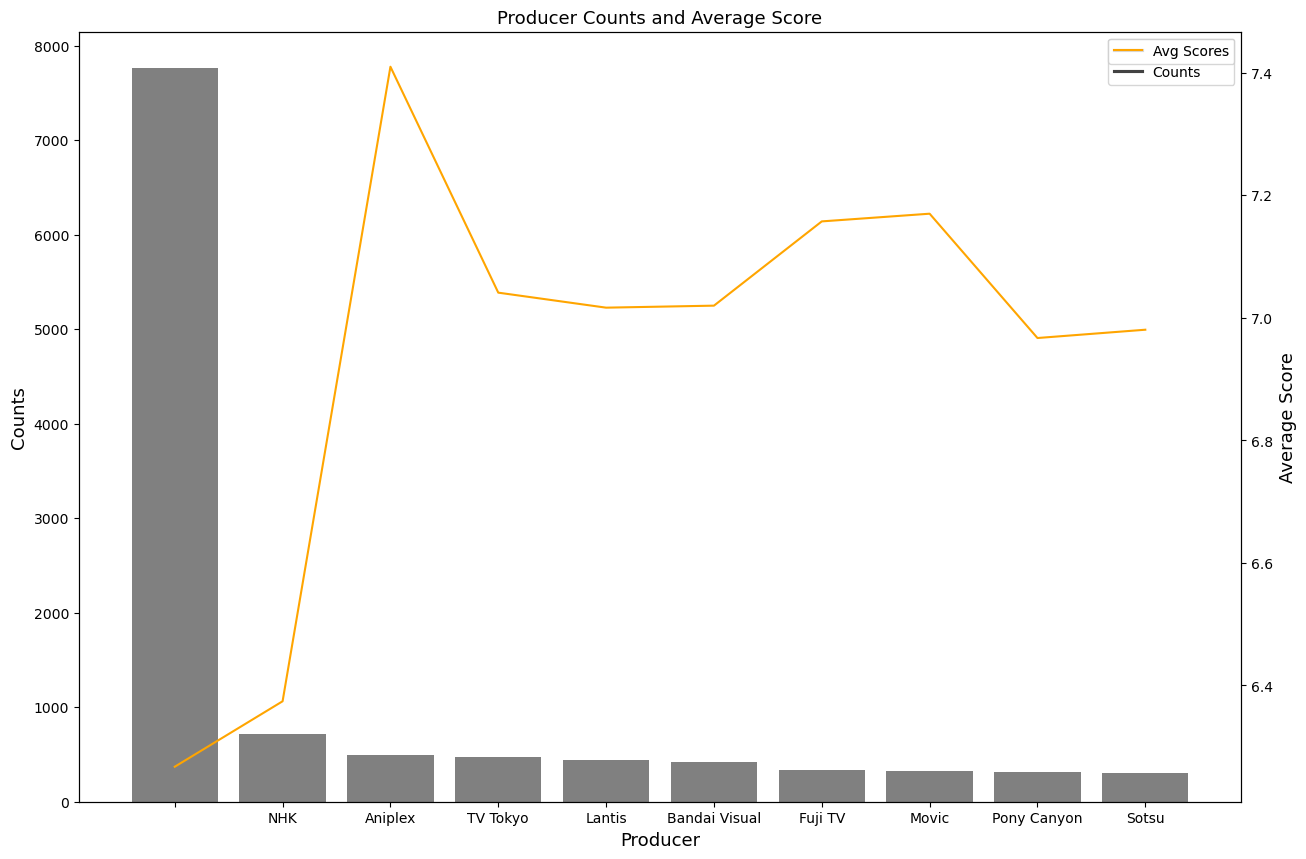

In [31]:
#plot the producer counts


fig, ax1 = plt.subplots(figsize=(15,10))

#bar plot creation
ax1.set_title('Producer Counts and Average Score', fontsize = 13)
ax1 = sns.barplot(x='Producer',y='Value_Count', data = prodscore_top10, color='grey', label = 'Counts')
ax1.set_xlabel('Producer', fontsize = 13)
ax1.set_ylabel('Counts', fontsize = 13)
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
#line plot creation
ax2 = sns.lineplot(x= 'Producer', y='Average_Score', data=prodscore_top10, color = 'orange', label = 'Avg Scores')
ax2.set_ylabel('Average Score', fontsize = 13)

ax2.tick_params(axis='y')

ax1.legend(loc='upper right', labels=['Avg Scores','Counts'])
plt.show()



In [32]:
# test = maldf3[maldf3[prod_col].apply(pd.Series.mean('Score'))]

## 1.4 Explore data for Studio

In [33]:
#string split the values in the producers column into multiple columns with 'Studio_' as prefix
maldf4 = maldf3.join(maldf3['Studios'].str.split(',',expand=True).add_prefix('Studio_').fillna(np.nan))

In [34]:
maldf4.head(100)

,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,...,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist, Fullmetal Alchemist (2009), FMA, FMAB",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,...,NaN,NaN,NaN,['Bones'],NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_no_Kyojin__The_Final_Season,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan Season 4",進撃の巨人 The Final Season,TV,16.0,Currently Airing,...,NaN,NaN,NaN,['MAPPA'],NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,...,NaN,NaN,NaN,['White Fox'],NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_no_Kyojin_Season_3_Part_2,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,...,NaN,NaN,NaN,['Wit Studio'],NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,...,NaN,NaN,NaN,['Bandai Namco Pictures'],NaN,NaN,NaN,NaN,NaN,NaN
5,5,5,Hunter x Hunter (2011),https://myanimelist.net/anime/11061/Hunter_x_Hunter_2011,Hunter x Hunter,HxH (2011),HUNTER×HUNTER（ハンター×ハンター）,TV,148.0,Finished Airing,...,NaN,NaN,NaN,['Madhouse'],NaN,NaN,NaN,NaN,NaN,NaN
6,6,6,Gintama',https://myanimelist.net/anime/9969/Gintama,Gintama Season 2,Gintama (2011),銀魂',TV,51.0,Finished Airing,...,NaN,NaN,NaN,['Sunrise'],NaN,NaN,NaN,NaN,NaN,NaN
7,7,7,Ginga Eiyuu Densetsu,https://myanimelist.net/anime/820/Ginga_Eiyuu_Densetsu,Legend of the Galactic Heroes,"LoGH, LotGH, Gin'eiden, GinEiDen, Heldensagen Vom Kosmosinsel",銀河英雄伝説,OVA,110.0,Finished Airing,...,NaN,NaN,NaN,['Artland','Magic Bus'],NaN,NaN,NaN,NaN,NaN
8,8,8,Gintama': Enchousen,https://myanimelist.net/anime/15417/Gintama__Enchousen,Gintama: Enchousen,"Gintama' (2012), Gintama' Overdrive, Kintama",銀魂' 延長戦,TV,13.0,Finished Airing,...,NaN,NaN,NaN,['Sunrise'],NaN,NaN,NaN,NaN,NaN,NaN
9,9,9,3-gatsu no Lion 2nd Season,https://myanimelist.net/anime/35180/3-gatsu_no_Lion_2nd_Season,March Comes In Like A Lion 2nd Season,Sangatsu no Lion Second Season,3月のライオン 第2シリーズ,TV,22.0,Finished Airing,...,NaN,NaN,NaN,['Shaft'],NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#select all the producer columns
stud_col = [col for col in maldf4 if col.startswith('Studio_')]
stud_col

['Studio_0',
 'Studio_1',
 'Studio_2',
 'Studio_3',
 'Studio_4',
 'Studio_5',
 'Studio_6']

In [36]:
#create a list of punctuation to remove
punctuation = ["\[", "\]" ,"\'", '\"'] 


for i in punctuation:
    maldf4[stud_col] = maldf4[stud_col].replace(i,"", regex=True)

In [37]:
#strip values in stud cols of whitespace
maldf4[stud_col] = maldf4[stud_col].apply(lambda x: x.str.strip())

In [38]:
#unpivot from genre values from wide to long using melt
studscore = maldf4.filter(regex=r'Score|Studio_').melt('Score', value_name='Studio')

In [39]:
#use a dictionary for groupby

studscore_dict = {'Value_Count': ('Studio', 'count'), 'Average_Score': ('Score', 'mean')}
studscore_df = studscore.groupby('Studio', as_index=False).agg(**studscore_dict)
studscore_df

,Studio,Value_Count,Average_Score
0,,7054,5.84994
1,10Gauge,6,6.65500
2,1IN,1,NaN
3,2:10 AM Animation,6,7.23000
4,33 Collective,1,NaN
...,...,...,...
712,monofilmo,2,7.34000
713,pH Studio,6,6.26000
714,production doA,4,7.06500
715,teamKG,3,6.24000


In [40]:
studscore_top10 = studscore_df.sort_values(['Value_Count','Average_Score'], ascending=False).head(10)

studscore_top10

,Studio,Value_Count,Average_Score
0,,7054,5.849940
633,Toei Animation,778,6.728027
588,Sunrise,499,6.913831
259,J.C.Staff,380,6.830809
321,Madhouse,364,6.979803
431,Production I.G,335,7.037788
600,TMS Entertainment,300,7.074690
530,Studio Deen,287,6.989885
561,Studio Pierrot,262,6.846667
371,OLM,236,6.620966


In [41]:
studscore_df['Studio'].nunique()

717

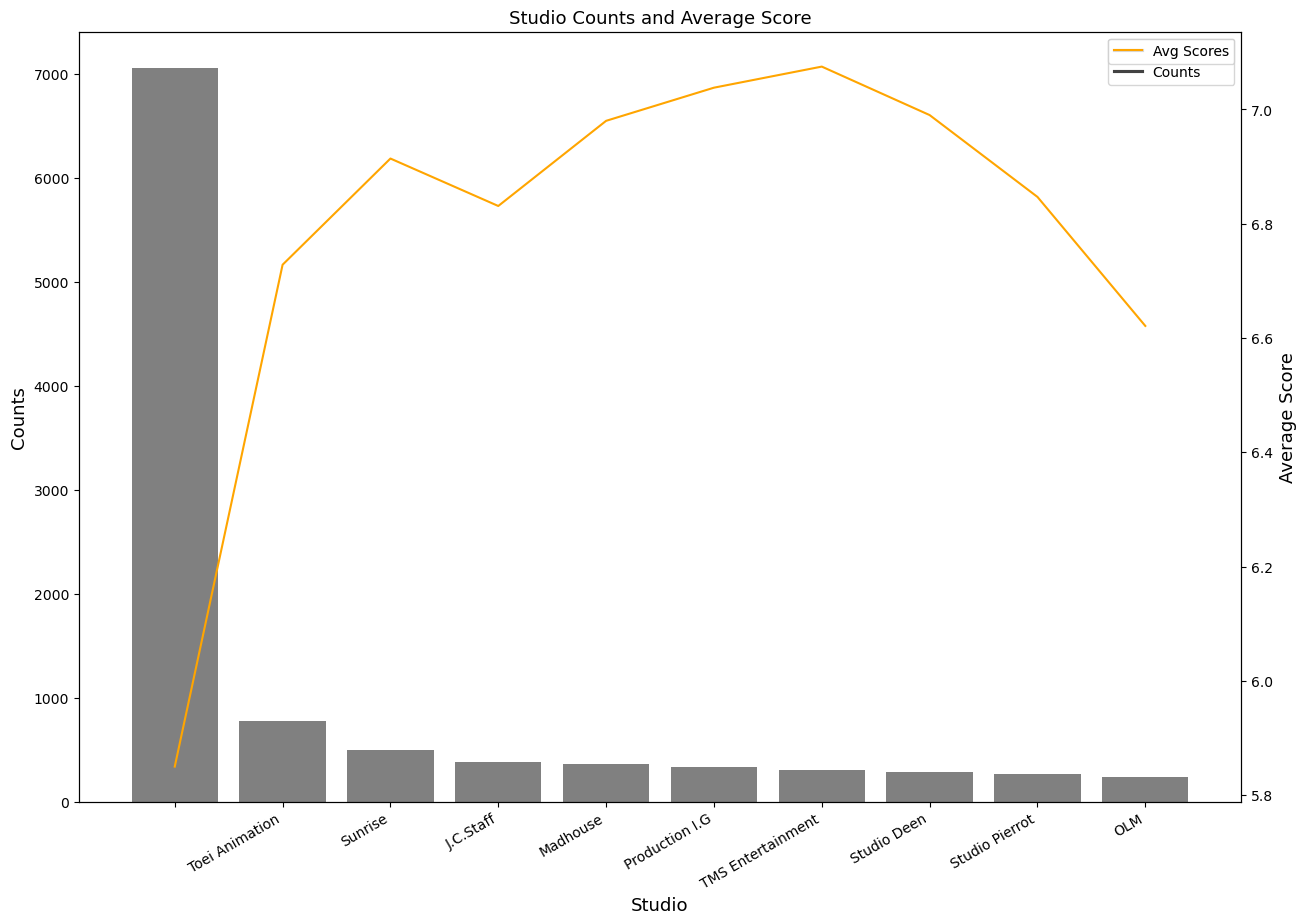

In [42]:
#plot the producer counts


fig, ax1 = plt.subplots(figsize=(15,10))

#bar plot creation
ax1.set_title('Studio Counts and Average Score', fontsize = 13)
ax1 = sns.barplot(x='Studio',y='Value_Count', data = studscore_top10, color='grey', label = 'Counts')
ax1.set_xlabel('Studio', fontsize = 13)
ax1.set_ylabel('Counts', fontsize = 13)
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
#line plot creation
ax2 = sns.lineplot(x= 'Studio', y='Average_Score', data=studscore_top10, color = 'orange', label = 'Avg Scores')
ax2.set_ylabel('Average Score', fontsize = 13)

ax2.tick_params(axis='y')

ax1.legend(loc='upper right', labels=['Avg Scores','Counts'])

plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# 2 NLP for Anime Synopsis

In [43]:
#create a copy of maldf4
maldf5 = maldf4.copy()

In [44]:
maldf5.head()

,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,...,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist, Fullmetal Alchemist (2009), FMA, FMAB",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,...,NaN,NaN,NaN,Bones,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_no_Kyojin__The_Final_Season,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan Season 4",進撃の巨人 The Final Season,TV,16.0,Currently Airing,...,NaN,NaN,NaN,MAPPA,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,...,NaN,NaN,NaN,White Fox,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_no_Kyojin_Season_3_Part_2,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,...,NaN,NaN,NaN,Wit Studio,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,...,NaN,NaN,NaN,Bandai Namco Pictures,NaN,NaN,NaN,NaN,NaN,NaN


## 2.1 Text pre processing

In [45]:
#number of counts for no synopsis information text
maldf5['Synopsis'].str.count("No synopsis information has been added to this title. Help improve our database by adding a synopsis here.| No synopsis has been added for this series yet.").sum()

832

In [46]:
#remove blank synopsis

noinfo = ('No synopsis information has been added to this title. Help improve our database by adding a synopsis here.', 
     'No synopsis has been added for this series yet.')

#check if the blank info is in a list
string_check = maldf5['Synopsis'].map(lambda x: x if not isinstance(x, list) else x[0])
#check if the values match the noinfo 
string_check = string_check.map(lambda s: any(noinfo_str in s for noinfo_str in noinfo))

#change the noinfo strings to blank
maldf5.loc[string_check, 'Synopsis'] = ""

In [47]:
maldf5.tail(50)

,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,...,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6
17439,17439,39,Kyuukyoku no Sex Adventure Kamasutra,https://myanimelist.net/anime/3910/Kyuukyoku_no_Sex_Adventure_Kamasutra,Kama Sutra,"Kama Sutra Kyuukyoku no Sex Adventure, Kyukioku no Sex Adventure Kamasutra, Kama Sutra: The Ultimate Sex Adventure",究極のSEXアドベンチャー カーマスートラ,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,animate Film,NaN,NaN,NaN,NaN,NaN,NaN
17440,17440,40,Punky Funky Baby,https://myanimelist.net/anime/12563/Punky_Funky_Baby,Punky Funky Baby,"Synphony Yume Monogatari, Symphony Yume Monogatari, Little Mermaid Series",パンキー ファンキー ベイビー,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17441,17441,41,Yayoi,https://myanimelist.net/anime/5561/Yayoi,NaN,Police Girl Yayoi,弥生,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17442,17442,42,Prima Donna Mai,https://myanimelist.net/anime/6903/Prima_Donna_Mai,NaN,NaN,プリマドンナ舞,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17443,17443,43,Injuu Nerawareta Idol,https://myanimelist.net/anime/3584/Injuu_Nerawareta_Idol,Idol of Darkness,NaN,淫獣 ねらわれたアイドル,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17444,17444,44,Kaguya-hime: Taketori Monogatari,https://myanimelist.net/anime/14471/Kaguya-hime__Taketori_Monogatari,NaN,Kaguyahime: Taketori Monogatari,かぐや姫 竹取物語,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17445,17445,45,Fairy Forest Remi-chan,https://myanimelist.net/anime/4601/Fairy_Forest_Remi-chan,Fairy Forest Remi-chan,Fairy in the Forest,フェアリーフォレスト レミちゃん,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17446,17446,46,Henbou Moral Hazard,https://myanimelist.net/anime/3540/Henbou_Moral_Hazard,NaN,Moral Hazard,変貌 モラルハザード,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17447,17447,47,Aoi Taiken,https://myanimelist.net/anime/8574/Aoi_Taiken,NaN,NaN,青い体験,OVA,2.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17448,17448,48,Chounouryoku Shoujo Barabanba,https://myanimelist.net/anime/5563/Chounouryoku_Shoujo_Barabanba,NaN,NaN,超能力少女バラバンバ,OVA,1.0,Finished Airing,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#remove the strings [Written by] and (Produced:) at the end of the string.
#following code replaces zero or more characters in between a [] or a () with blankspace

maldf5['Synopsis'] = maldf5['Synopsis'].str.replace(r'\s*(?:\[[^][]*]|\([^()]*\))\s*$', '')

In [49]:
# First convert all reviews into a list
data = maldf5['Synopsis'].values.tolist()
data[:20]

['"In order for something to be obtained, something of equal value must be lost."\n\nAlchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward\'s right arm that he is able to affix Alphonse\'s soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called "automail" and become a state alchemist, the Fullmetal Alchemist.\n\nThree years of searching later, the brothers seek the Philosopher\'s Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes 

In [50]:
# Remove new line characters
data = [re.sub('\s+', ' ', text) for text in data]

# Remove single quotes
data = [re.sub("\'", "", text) for text in data] 

# Remove new line characters
data = [re.sub('-', ' ', text) for text in data]

# Remove whitespace in front
data = [re.sub("\n", "", text) for text in data] 

# Remove whitespace at back
data = [re.sub("\s+\Z", "", text) for text in data] 

# Changing all characters to lower case
data = [text.lower() for text in data]

# Removing non-alpha characters
data = [re.sub('[^A-Za-z]+', ' ', text) for text in data]

data[:20]

[' in order for something to be obtained something of equal value must be lost alchemy is bound by this law of equivalent exchange something the young brothers edward and alphonse elric only realize after attempting human transmutation the one forbidden act of alchemy they pay a terrible price for their transgression edward loses his left leg alphonse his physical body it is only by the desperate sacrifice of edwards right arm that he is able to affix alphonses soul to a suit of armor devastated and alone it is the hope that they would both eventually return to their original bodies that gives edward the inspiration to obtain metal limbs called automail and become a state alchemist the fullmetal alchemist three years of searching later the brothers seek the philosophers stone a mythical relic that allows an alchemist to overcome the law of equivalent exchange even with military allies colonel roy mustang lieutenant riza hawkeye and lieutenant colonel maes hughes on their side the broth

## 2.2 Tokenize words, and perform further text clean-up

In [51]:
# Creating a function to utilize the simple_preprocess function of Gensim
# Helps to tokenize each sentence into a list of words, and removes punctuations and unnecessary characters

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
# Converting output tokens into a list
data_words = list(sent_to_words(data))

print(data_words[:1])

[['in', 'order', 'for', 'something', 'to', 'be', 'obtained', 'something', 'of', 'equal', 'value', 'must', 'be', 'lost', 'alchemy', 'is', 'bound', 'by', 'this', 'law', 'of', 'equivalent', 'exchange', 'something', 'the', 'young', 'brothers', 'edward', 'and', 'alphonse', 'elric', 'only', 'realize', 'after', 'attempting', 'human', 'transmutation', 'the', 'one', 'forbidden', 'act', 'of', 'alchemy', 'they', 'pay', 'terrible', 'price', 'for', 'their', 'transgression', 'edward', 'loses', 'his', 'left', 'leg', 'alphonse', 'his', 'physical', 'body', 'it', 'is', 'only', 'by', 'the', 'desperate', 'sacrifice', 'of', 'edwards', 'right', 'arm', 'that', 'he', 'is', 'able', 'to', 'affix', 'alphonses', 'soul', 'to', 'suit', 'of', 'armor', 'devastated', 'and', 'alone', 'it', 'is', 'the', 'hope', 'that', 'they', 'would', 'both', 'eventually', 'return', 'to', 'their', 'original', 'bodies', 'that', 'gives', 'edward', 'the', 'inspiration', 'to', 'obtain', 'metal', 'limbs', 'called', 'automail', 'and', 'becom

## 2.3 Create Bigrams and Trigrams

In [52]:
# Create the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [53]:
# Faster way to get a sentence as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [54]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['in', 'order', 'for', 'something', 'to', 'be', 'obtained', 'something', 'of', 'equal', 'value', 'must', 'be', 'lost', 'alchemy', 'is', 'bound', 'by', 'this', 'law', 'of', 'equivalent', 'exchange', 'something', 'the', 'young', 'brothers', 'edward', 'and', 'alphonse', 'elric', 'only', 'realize', 'after', 'attempting', 'human', 'transmutation', 'the', 'one', 'forbidden', 'act', 'of', 'alchemy', 'they', 'pay', 'terrible', 'price', 'for', 'their', 'transgression', 'edward', 'loses', 'his', 'left', 'leg', 'alphonse', 'his', 'physical', 'body', 'it', 'is', 'only', 'by', 'the', 'desperate', 'sacrifice', 'of', 'edwards', 'right_arm', 'that', 'he', 'is', 'able', 'to', 'affix', 'alphonses', 'soul', 'to', 'suit', 'of', 'armor', 'devastated', 'and', 'alone', 'it', 'is', 'the', 'hope', 'that', 'they', 'would', 'both', 'eventually', 'return', 'to', 'their', 'original', 'bodies', 'that', 'gives', 'edward', 'the', 'inspiration', 'to', 'obtain', 'metal', 'limbs', 'called', 'automail', 'and', 'become', 

In [55]:
# Define stopwords
stop_words = stopwords.words('english')
stop_words.append('anime')
stop_words.append('animation')
stop_words.append('story')
stop_words.append('episode')
stop_words.append('series')

In [56]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [57]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [58]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [59]:
# Initialize spacy 'en' model, and disabling the parser and named entity recognition
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])


In [60]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [61]:
data_lemmatized_nostop = remove_stopwords(data_lemmatized)

In [62]:
# Create Dictionary and Corpus needed for Topic Modeling
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus

id2word = corpora.Dictionary(data_lemmatized_nostop)

# Create Corpus
texts = data_lemmatized_nostop

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View (term, document frequency)
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1)]]


In [63]:
# Example of one of the words in our dictionary
id2word[4]

'alchemy'

## 2.4 Build LDA Mallet Model

In [64]:
# Define the mallet path by pointing it to the mallet file found in the bin
mallet_path = '/home/aligator/.aur/Mallet/bin/mallet' 

In [65]:
# Initializing the LDA mallet model
from ldamallet import LdaMallet
n_topics = 8
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, id2word=id2word)

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 205
total tokens: 425732
<10> LL/token: -10.02579
<20> LL/token: -9.76286
<30> LL/token: -9.54233
<40> LL/token: -9.32989

0	6.25	life live day friend write find city man back world people turn time mal_rewrite girl death home place meet change 
1	6.25	find girl write work source make day mal_rewrite meet begin young give friend night feeling follow decide woman time brother 
2	6.25	source boy family child live ann year mother village leave father day lose young girl forest heart dog home dream 
3	6.25	world mal_rewrite write force young group mysterious human call face power magic ability strange find people man rescue battle set 
4	6.25	world earth fight power human save war battle planet evil monster attack space demon year order king robot protect destroy 
5	6.25	source short movie base release feature character film original tv adventure make include time girl japanese ann version season volume 
6	6.25	gir

In [66]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('life', 0.04592299295058005),
   ('find', 0.03657927359520417),
   ('live', 0.033933428312394764),
   ('time', 0.02401613410550077),
   ('leave', 0.018298888004884637),
   ('home', 0.015579033063814827),
   ('begin', 0.014838936481210797),
   ('lose', 0.012600144318833608),
   ('return', 0.012452125002312802),
   ('change', 0.011952559809055081)]),
 (1,
  [('man', 0.026041473457728975),
   ('write', 0.022183477389917276),
   ('mal_rewrite', 0.01789887598768409),
   ('work', 0.015246503691063546),
   ('woman', 0.014690061950513781),
   ('begin', 0.012241718292094817),
   ('young', 0.011666728493526728),
   ('end', 0.011314315391178543),
   ('night', 0.010572393070445524),
   ('find', 0.010034499387914085)]),
 (2,
  [('source', 0.09635655595653149),
   ('ann', 0.03335576080086448),
   ('boy', 0.028584826798784838),
   ('family', 0.02087793341081004),
   ('young', 0.018227414520765796),
   ('child', 0.01741187024690603),
   ('set', 0.015597284237568046),
   ('mother', 0.013191428

### 2.4.1 Compute coherence score 

Coherence Values are a measure of the degree of semantic similarity between high scoring words in the topics. 

In [67]:
%%time

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized_nostop, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6547390820671911
CPU times: user 623 ms, sys: 184 ms, total: 807 ms
Wall time: 1.64 s


### 2.4.2 Determining optimal number of topics

In [68]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics
    c_v coherence score is between 0-1, with 0.6 to 0.7 representing good score 

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [69]:
%%time

# This will require some time to run as it loops over different topics
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized_nostop, 
                                                        start=2, 
                                                        limit=12, step=1)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 205
total tokens: 425732
<10> LL/token: -8.99068
<20> LL/token: -8.91825
<30> LL/token: -8.8595
<40> LL/token: -8.79623

0	25	source girl day short ann make love live song feature base special time find life film world boy include release 
1	25	write world mal_rewrite life find begin power friend girl mysterious fight school human source earth year time make young order 

<50> LL/token: -8.7241
<60> LL/token: -8.66504
<70> LL/token: -8.61852
<80> LL/token: -8.58615
<90> LL/token: -8.56108

0	25	source girl day make school ann short live time boy love special base game work song feature friend film life 
1	25	world write mal_rewrite find life begin year power human mysterious fight call earth friend order people battle force leave city 

<100> LL/token: -8.54185
<110> LL/token: -8.52939
<120> LL/token: -8.51664
<130> LL/token: -8.50719
<140> LL/token: -8.49791

0	25	source girl day make school ann live short frien

CPU times: user 14.2 s, sys: 2.02 s, total: 16.2 s
Wall time: 3min 47s


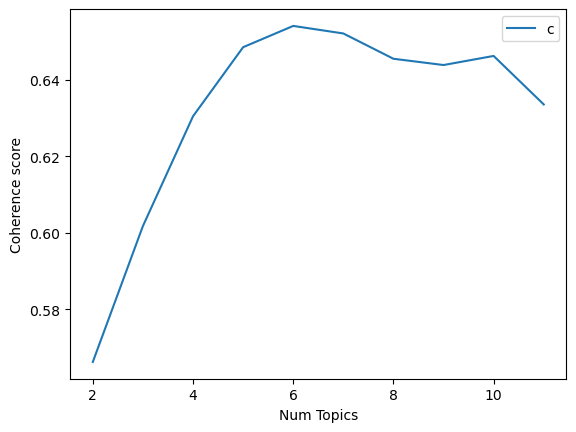

In [70]:
# Display coherence score vs number of topics plot
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num of Topics =", m, " has Coherence Value of", round(cv, 4))

Num of Topics = 2  has Coherence Value of 0.5662
Num of Topics = 3  has Coherence Value of 0.6017
Num of Topics = 4  has Coherence Value of 0.6304
Num of Topics = 5  has Coherence Value of 0.6485
Num of Topics = 6  has Coherence Value of 0.6541
Num of Topics = 7  has Coherence Value of 0.6521
Num of Topics = 8  has Coherence Value of 0.6455
Num of Topics = 9  has Coherence Value of 0.6438
Num of Topics = 10  has Coherence Value of 0.6462
Num of Topics = 11  has Coherence Value of 0.6335


If the coherence score is continuously increasing, it may make better sense to use the elbow method and pick the model with lesser topics that gave the highest CV before it plateaus

#### 2.4.2.1 Exploring 5 topics

In [72]:
# Select the model and print the topics
optimal_model = model_list[3] # Based on the indices above, 5 topics appear to perform the best while still remaining in a meaningful range
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.038*"girl" + 0.026*"day" + 0.021*"live" + 0.015*"boy" + 0.015*"love" + '
  '0.013*"source" + 0.013*"find" + 0.012*"time" + 0.012*"life" + 0.012*"make"'),
 (1,
  '0.023*"world" + 0.016*"find" + 0.013*"people" + 0.010*"set" + 0.009*"power" '
  '+ 0.009*"mysterious" + 0.008*"man" + 0.008*"return" + 0.007*"life" + '
  '0.007*"order"'),
 (2,
  '0.023*"write" + 0.023*"friend" + 0.021*"school" + 0.021*"mal_rewrite" + '
  '0.015*"student" + 0.012*"make" + 0.010*"life" + 0.010*"year" + '
  '0.010*"dream" + 0.009*"team"'),
 (3,
  '0.044*"source" + 0.019*"short" + 0.015*"special" + 0.015*"base" + '
  '0.014*"song" + 0.014*"feature" + 0.013*"film" + 0.012*"include" + '
  '0.012*"release" + 0.011*"show"'),
 (4,
  '0.015*"human" + 0.014*"fight" + 0.013*"earth" + 0.012*"call" + '
  '0.012*"world" + 0.011*"source" + 0.011*"battle" + 0.010*"force" + '
  '0.010*"city" + 0.010*"year"')]


In [73]:
# Visualize the topics with pyLDAvis (ignore warnings)
from ldamallet import malletmodel2ldamodel
pyLDAvis.enable_notebook()
optimal_model_vis = malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.138461  0.136498       1        1  20.912822
1     -0.173532 -0.084667       2        1  20.868797
4      0.015034 -0.362590       3        1  20.778984
0     -0.120752  0.223132       4        1  20.391904
3      0.417711  0.087626       5        1  17.047493, topic_info=        Term         Freq        Total Category  logprob  loglift
681     girl  3741.000000  3741.000000  Default  30.0000  30.0000
1314  source  5954.000000  5954.000000  Default  29.0000  29.0000
675      day  2587.000000  2587.000000  Default  28.0000  28.0000
274   friend  2298.000000  2298.000000  Default  27.0000  27.0000
528   school  2110.000000  2110.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
699   create   568.403878   737.550783   Topic5  -4.9717   1.5087
2034     ann   924.340795  1825.301209   Topic5  -4.4854   1.0887
803    event   508.168399   726.187670   Topic5  -5.0837   1.4122
444     real   398.649348   473.985850   Topic5  -5.3264   1.5961
509     game   514.739542  1239.568007   Topic5  -5.0709   0.8903

[391 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
320       1  1.002283        achieve
459       1  1.001222  action_packed
321       2  0.657231      adventure
321       5  0.342960      adventure
494       1  1.035355   affectionate
...     ...       ...            ...
83        3  0.492455           year
84        2  0.309247          young
84        3  0.109714          young
84        4  0.578132          young
84        5  0.002842          young

[417 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

#### 2.4.2.2 Explore 3 topics 

In [74]:
# Select the model and print the topics
optimal_model = model_list[1] # 3 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.022*"girl" + 0.017*"life" + 0.015*"day" + 0.013*"friend" + 0.012*"write" '
  '+ 0.012*"school" + 0.012*"live" + 0.011*"find" + 0.011*"mal_rewrite" + '
  '0.009*"boy"'),
 (1,
  '0.043*"source" + 0.013*"ann" + 0.011*"short" + 0.009*"special" + '
  '0.009*"base" + 0.009*"game" + 0.009*"song" + 0.008*"feature" + '
  '0.008*"follow" + 0.008*"film"'),
 (2,
  '0.021*"world" + 0.009*"power" + 0.009*"human" + 0.008*"call" + '
  '0.008*"mysterious" + 0.008*"fight" + 0.007*"earth" + 0.007*"people" + '
  '0.006*"order" + 0.006*"battle"')]


In [75]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.222939  0.286251       1        1  35.537211
0     -0.168092 -0.314331       2        1  35.051399
1      0.391031  0.028080       3        1  29.411390, topic_info=        Term         Freq        Total Category  logprob  loglift
1314  source  6137.000000  6137.000000  Default  30.0000  30.0000
681     girl  3746.000000  3746.000000  Default  29.0000  29.0000
138    world  3507.000000  3507.000000  Default  28.0000  28.0000
115     life  2920.000000  2920.000000  Default  27.0000  27.0000
675      day  2591.000000  2591.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
520     play   693.240348   752.927244   Topic3  -5.3185   1.1412
317     work   957.495333  1436.116667   Topic3  -4.9956   0.8184
76      time  1092.482727  2209.641229   Topic3  -4.8637   0.5194
46      make  1099.346493  2397.818018   Topic3  -4.8574   0.4439
128      set   660.065480  1180.748601   Topic3  -5.3676   0.6422

[224 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1715      1  1.000459    ability
139       3  1.019848    acclaim
1         2  0.998963        act
141       3  1.000845      adapt
321       3  0.999768  adventure
...     ...       ...        ...
82        2  0.769102      write
83        1  0.521573       year
83        2  0.478668       year
84        1  0.391709      young
84        2  0.608436      young

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

#### 2.4.2.3 Explore 4 topics

In [76]:
# Select the model and print the topics
optimal_model = model_list[2] # 4 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.030*"girl" + 0.023*"life" + 0.021*"day" + 0.018*"write" + 0.017*"school" '
  '+ 0.015*"mal_rewrite" + 0.012*"student" + 0.011*"love" + 0.011*"live" + '
  '0.008*"friend"'),
 (1,
  '0.020*"find" + 0.012*"young" + 0.012*"boy" + 0.012*"time" + 0.011*"year" + '
  '0.010*"friend" + 0.009*"leave" + 0.008*"people" + 0.008*"team" + '
  '0.008*"child"'),
 (2,
  '0.054*"source" + 0.018*"ann" + 0.015*"short" + 0.012*"special" + '
  '0.012*"base" + 0.012*"game" + 0.012*"song" + 0.011*"feature" + 0.010*"film" '
  '+ 0.010*"include"'),
 (3,
  '0.027*"world" + 0.011*"power" + 0.011*"human" + 0.011*"call" + '
  '0.011*"mysterious" + 0.010*"fight" + 0.009*"earth" + 0.008*"battle" + '
  '0.008*"force" + 0.007*"city"')]


In [77]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.157851  0.361427       1        1  26.985636
0     -0.123293 -0.262138       2        1  26.105645
1     -0.140709 -0.118418       3        1  25.345687
2      0.421853  0.019128       4        1  21.563032, topic_info=        Term         Freq        Total Category  logprob  loglift
1314  source  6040.000000  6040.000000  Default  30.0000  30.0000
681     girl  3771.000000  3771.000000  Default  29.0000  29.0000
138    world  3471.000000  3471.000000  Default  28.0000  28.0000
115     life  2939.000000  2939.000000  Default  27.0000  27.0000
675      day  2608.000000  2608.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1314  source  5608.630636  6040.838761   Topic4  -2.9174   1.4600
1905    star   457.457449   465.525334   Topic4  -5.4238   1.5167
224   follow   577.722675  1285.546410   Topic4  -5.1904   0.7343
317     work   522.647945  1426.124333   Topic4  -5.2906   0.5304
46      make   575.474727  2406.606221   Topic4  -5.1943   0.1034

[305 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1715      1  0.999173        ability
3943      2  0.999768       acquaint
459       4  1.016800  action_packed
1513      4  1.000913            add
847       2  0.999768         affect
...     ...       ...            ...
82        2  0.815125          write
83        1  0.329222           year
83        3  0.670695           year
84        2  0.184136          young
84        3  0.816018          young

[321 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

#### 2.4.2.4 Explore 6 topics

In [78]:
# Select the model and print the topics
optimal_model = model_list[4] # 6 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.020*"find" + 0.020*"write" + 0.017*"work" + 0.017*"man" + '
  '0.016*"mal_rewrite" + 0.013*"life" + 0.012*"time" + 0.010*"follow" + '
  '0.010*"begin" + 0.009*"face"'),
 (1,
  '0.030*"source" + 0.015*"earth" + 0.015*"call" + 0.015*"ann" + 0.014*"fight" '
  '+ 0.013*"battle" + 0.012*"year" + 0.012*"force" + 0.010*"war" + '
  '0.009*"mysterious"'),
 (2,
  '0.036*"girl" + 0.032*"day" + 0.024*"live" + 0.018*"source" + 0.017*"love" + '
  '0.014*"family" + 0.013*"time" + 0.013*"make" + 0.012*"home" + '
  '0.012*"child"'),
 (3,
  '0.030*"source" + 0.022*"short" + 0.018*"special" + 0.017*"base" + '
  '0.017*"song" + 0.016*"feature" + 0.015*"film" + 0.014*"include" + '
  '0.014*"release" + 0.013*"show"'),
 (4,
  '0.028*"friend" + 0.026*"school" + 0.018*"student" + 0.015*"mal_rewrite" + '
  '0.014*"write" + 0.013*"make" + 0.011*"team" + 0.011*"year" + 0.010*"member" '
  '+ 0.010*"girl"'),
 (5,
  '0.041*"world" + 0.018*"power" + 0.011*"set" + 0.011*"human" + 0.011*"save" '
  '+ 0.011*"p

In [79]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.165305  0.062563       1        1  17.294845
4     -0.178713  0.160413       2        1  17.266901
5     -0.023855 -0.305672       3        1  17.222685
1      0.144191 -0.236855       4        1  17.084731
2     -0.154733  0.103258       5        1  16.965966
3      0.378413  0.216292       6        1  14.164872, topic_info=        Term         Freq        Total Category  logprob  loglift
138    world  3576.000000  3576.000000  Default  30.0000  30.0000
681     girl  3742.000000  3742.000000  Default  29.0000  29.0000
1314  source  5951.000000  5951.000000  Default  28.0000  28.0000
675      day  2574.000000  2574.000000  Default  27.0000  27.0000
274   friend  2310.000000  2310.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
699   create   427.939155   731.010156   Topic6  -5.0703   1.4190
2034     ann   615.295600  1825.292278   Topic6  -4.7072   0.8670
509     game   433.261781  1234.033707   Topic6  -5.0580   0.9077
444     real   334.260932   467.340507   Topic6  -5.3174   1.6193
803    event   336.389982   727.439922   Topic6  -5.3110   1.1831

[475 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1715      3  1.000651  ability
210       3  0.976762  absence
3589      2  1.001230  academy
139       6  0.991574  acclaim
1         1  1.000266      act
...     ...       ...      ...
83        4  0.519989     year
84        1  0.044195    young
84        3  0.405117    young
84        4  0.179045    young
84        5  0.371688    young

[540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 6, 2, 3, 4])

#### 2.4.2.5 Explore 8 topics

In [80]:
# Select the model and print the topics
optimal_model = model_list[6] # 8 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.109*"source" + 0.033*"ann" + 0.014*"work" + 0.014*"make" + 0.010*"run" + '
  '0.009*"event" + 0.009*"follow" + 0.008*"real" + 0.008*"adventure" + '
  '0.008*"set"'),
 (1,
  '0.020*"earth" + 0.016*"fight" + 0.016*"force" + 0.013*"city" + 0.013*"war" '
  '+ 0.012*"year" + 0.012*"call" + 0.011*"planet" + 0.011*"human" + '
  '0.011*"battle"'),
 (2,
  '0.056*"world" + 0.022*"power" + 0.020*"mysterious" + 0.018*"find" + '
  '0.013*"strange" + 0.013*"human" + 0.011*"people" + 0.011*"save" + '
  '0.011*"discover" + 0.011*"call"'),
 (3,
  '0.016*"team" + 0.013*"set" + 0.012*"great" + 0.011*"face" + 0.010*"order" + '
  '0.010*"travel" + 0.009*"bring" + 0.009*"land" + 0.009*"hero" + '
  '0.008*"continue"'),
 (4,
  '0.063*"girl" + 0.024*"love" + 0.020*"make" + 0.020*"day" + 0.016*"man" + '
  '0.016*"dream" + 0.015*"woman" + 0.013*"good" + 0.013*"thing" + '
  '0.012*"give"'),
 (5,
  '0.030*"short" + 0.024*"special" + 0.023*"game" + 0.022*"song" + '
  '0.022*"feature" + 0.020*"film" + 0.01

In [81]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.088629 -0.085616       1        1  13.403405
1     -0.261832  0.180248       2        1  13.294147
2     -0.204041  0.032649       3        1  13.179409
3     -0.110598 -0.000521       4        1  12.728304
6      0.039205 -0.247147       5        1  12.659962
4      0.139766 -0.232426       6        1  12.612063
0      0.233961  0.032030       7        1  11.679254
5      0.252169  0.320783       8        1  10.443455, topic_info=             Term         Freq        Total Category  logprob  loglift
1314       source  6148.000000  6148.000000  Default  30.0000  30.0000
681          girl  3803.000000  3803.000000  Default  29.0000  29.0000
138         world  3548.000000  3548.000000  Default  28.0000  28.0000
82          write  2753.000000  2753.000000  Default  27.0000  27.0000
47    mal_rewrite  2524.000000  2524.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1267        manga   350.919067   353.211250   Topic8  -4.9639   2.2527
694          base   794.789910  1192.483747   Topic8  -4.1464   1.8535
232          part   519.067786   784.750970   Topic8  -4.5725   1.8459
1905         star   326.897821   440.766813   Topic8  -5.0349   1.9603
699        create   379.117920   727.529812   Topic8  -4.8867   1.6074

[579 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1715      1  0.001637  ability
1715      3  0.998817  ability
210       5  0.979490  absence
795       1  0.999908   accept
139       8  1.010679  acclaim
...     ...       ...      ...
83        4  0.224718     year
84        4  0.276684    young
84        5  0.457959    young
84        6  0.264898    young
84        8  0.000561    young

[676 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 3, 4, 7, 5, 1, 6])

#### 2.4.2.6 Selecting 5 topics as optimal model based on above exploration

In [82]:
# Select the model and print the topics
optimal_model = model_list[3] # 5 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.038*"girl" + 0.026*"day" + 0.021*"live" + 0.015*"boy" + 0.015*"love" + '
  '0.013*"source" + 0.013*"find" + 0.012*"time" + 0.012*"life" + 0.012*"make"'),
 (1,
  '0.023*"world" + 0.016*"find" + 0.013*"people" + 0.010*"set" + 0.009*"power" '
  '+ 0.009*"mysterious" + 0.008*"man" + 0.008*"return" + 0.007*"life" + '
  '0.007*"order"'),
 (2,
  '0.023*"write" + 0.023*"friend" + 0.021*"school" + 0.021*"mal_rewrite" + '
  '0.015*"student" + 0.012*"make" + 0.010*"life" + 0.010*"year" + '
  '0.010*"dream" + 0.009*"team"'),
 (3,
  '0.044*"source" + 0.019*"short" + 0.015*"special" + 0.015*"base" + '
  '0.014*"song" + 0.014*"feature" + 0.013*"film" + 0.012*"include" + '
  '0.012*"release" + 0.011*"show"'),
 (4,
  '0.015*"human" + 0.014*"fight" + 0.013*"earth" + 0.012*"call" + '
  '0.012*"world" + 0.011*"source" + 0.011*"battle" + 0.010*"force" + '
  '0.010*"city" + 0.010*"year"')]


topic 0: Anime about war or battles on earth

topic 1: Anime about membership in a club or group

topic 2: Anime about love story set in school

topic 3: Anime featuring songs, films or videos

topic 4: Anime about family life


## 2.5 Finding the dominant topic in each sentence (i.e. Assign topic number for each review)
Finding the topic number that has the highest percentage contribution in that document.

In [83]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data_lemmatized_nostop):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df._append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)




In [84]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Anime_Number', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



In [85]:
# Display dataframe
df_dominant_topic.tail(50)

,Anime_Number,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
17439,17439,1,0.3286,"world, find, people, set, power, mysterious, man, return, life, order",hidden deep in the ancient himalayan mountains a beautiful princess is found in the ice dr aikawa revives the sensual princess in his own special way now that the lovely princess surya has been brought back to life the fun begins with love struck eyes ryuu dr aikawas son decides he must master the positions of the ancient art of love as described in the classic indian text the kama sutra little does he realize how much trouble a beautiful princess can be until he finds he must protect her from the vicious indian cult the mali clan
17440,17440,3,0.2182,"source, short, special, base, song, feature, film, include, release, show",part of little mermaid series along with telepathist iq saiko shining may and suashi no houkago
17441,17441,3,0.3131,"source, short, special, base, song, feature, film, include, release, show",doujin video produced by noted ero mangaka and erogame character designer shinda mane based on one of his union of the snake doujinshi featuring the cute yuri police girls he was rather fond of originally released on vhs at the rd comiket in winter source anidb
17442,17442,0,0.3827,"girl, day, live, boy, love, source, find, time, life, make",mai and her gymnastics trainer are secretly in love with each other unfortunately she has a boyfriend while her teacher is married to the daughter of the school s director despite all that and the fact that they are teacher and student they both give in to their desires and everything works just fine between them too bad the wife finds out and she s not happy that she lost her husband to a little girl she persuades mai s boyfriend to help her and together they carry out a plan to punish and publicly humiliate mai source anidb
17443,17443,1,0.2647,"world, find, people, set, power, mysterious, man, return, life, order",ikumi is an up and coming pop singer with millions of fans and a promising acting career she should be looking at the world through rose colored glasses but she s got man trouble the love of her life just isn t sure he can handle ikumi s fame and fortune to make matters worse while shooting on location a jealous co star finds a strange wooden idol in an abandoned temple and uses it to invoke a hedeous demon to be the instrument of her revenge will ikumi s next concert be her last curtain call she s about to dicover that there really are fates worse than death
17444,17444,3,0.2759,"source, short, special, base, song, feature, film, include, release, show",an erotic version of the classical japanese folktale the tale of the bamboo cutter produced by tokyo studio
17445,17445,1,0.2879,"world, find, people, set, power, mysterious, man, return, life, order",take a mystical journey to an enchanted forest where this fairy will fulfill your every sexual desire but will his dark past manifest itself in the form of love or anger and lead them down a dark road source anidb
17446,17446,0,0.3981,"girl, day, live, boy, love, source, find, time, life, make",one day while walking home from school a young college girl is followed by a creepy old man she runs to a nearby park in an attempt to get away from him but is captured by someone hiding in the shadows the pervert strips her naked and mercilessly has his way with her another man hearing her cries for help comes to her aid and chases the pervert away but as our girl quickly gathers up her clothes and turns to get dressed her rescuer starts having lusty thoughts of his own schoolgirls bring out the animal in everyone and watch how these guys treat our schoolgirl like a bitch in heat who can i believe somebody help me
17447,17447,3,0.2951,"source, short, special, base, song, feature, film, include, release, show",one of the first erotic ova based in an original story of mangaka hachurui it would also have a live action version released almost at the same time and starring av actr

## 2.6 Merging the topics into original df_positive dataframe

In [86]:
df_dominant_topic.shape

(17489, 5)

In [87]:
maldf5.shape

(17489, 81)

In [88]:
maldf6 = maldf5.reset_index()

In [89]:
maldf_final = pd.concat([maldf6, df_dominant_topic], axis=1)

In [90]:
maldf_final.head()

,index,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,...,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6,Anime_Number,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist, Fullmetal Alchemist (2009), FMA, FMAB",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,...,NaN,NaN,NaN,NaN,NaN,0,1,0.3099,"world, find, people, set, power, mysterious, man, return, life, order",in order for something to be obtained something of equal value must be lost alchemy is bound by this law of equivalent exchange something the young brothers edward and alphonse elric only realize after attempting human transmutation the one forbidden act of alchemy they pay a terrible price for their transgression edward loses his left leg alphonse his physical body it is only by the desperate sacrifice of edwards right arm that he is able to affix alphonses soul to a suit of armor devastated and alone it is the hope that they would both eventually return to their original bodies that gives edward the inspiration to obtain metal limbs called automail and become a state alchemist the fullmetal alchemist three years of searching later the brothers seek the philosophers stone a mythical relic that allows an alchemist to overcome the law of equivalent exchange even with military allies colonel roy mustang lieutenant riza hawkeye and lieutenant colonel maes hughes on their side the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive philosophers stone but their countrys murky history as well in between finding a serial killer and racing against time edward and alphonse must ask themselves if what they are doing will make them human again or take away their humanity written by mal rewrite
1,1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_no_Kyojin__The_Final_Season,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan Season 4",進撃の巨人 The Final Season,TV,16.0,...,NaN,NaN,NaN,NaN,NaN,1,4,0.3053,"human, fight, earth, call, world, source, battle, force, city, year",gabi braun and falco grice have been training their entire lives to inherit one of the seven titans under marleys control and aid their nation in eradicating the eldians on paradis however just as all seems well for the two cadets their peace is suddenly shaken by the arrival of eren yeager and the remaining members of the survey corps having finally reached the yeager family basement and learned about the dark history surrounding the titans the survey corps has at long last found the answer they so desperately fought to uncover with the truth now in their hands the group set out for the world beyond the walls in shingeki no kyojin the final season two utterly different worlds collide as each party pursues its own agenda in the long awaited conclusion to paradis fight for freedom written by mal rewrite
2,2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,...,NaN,NaN,NaN,NaN,NaN,2,4,0.2604,"human, fight, earth, call, world, source, battle, force, city, year",the self proclaimed mad scientist rintarou okabe rents out a room in a rickety old building in akihabara where he indulges himself in his hobby of inventing prospective future gadgets with fellow lab members mayuri shiina his air headed childhood friend and hashida itaru a perverted hacker nicknamed daru the three pass the time by tinkering with their most promising contraption yet a machine dubbed the phone microwave which performs the strange function of morphing bananas into piles of green gel though miraculous in itself the phenomenon doesnt provide anything concrete in okabes search for a scientific breakthrough that is until the lab members are spurred into action by a string of mysterious

### 2.6.1 Assigning topics descriptions

In [91]:
#topic descriptions for the 5 topics
topic_mapping = {0:'Anime about war or battles on earth',
                 1:'Anime about membership in a club or group',
                 2:'Anime about love story set in school',
                 3:'Anime featuring songs, films or videos',
                 4:'Anime about family life'}

In [92]:
maldf_final['Topic_Category'] = maldf_final['Dominant_Topic'].map(topic_mapping)

In [93]:
maldf_final.tail()

,index,Unnamed: 0.1,Unnamed: 0,Title,URL,English,Synonyms,Japanese,Type,Episodes,...,Studio_3,Studio_4,Studio_5,Studio_6,Anime_Number,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic_Category
17484,17484,17484,34,Konbini Shoujo Z,https://myanimelist.net/anime/42383/Konbini_Shoujo_Z,NaN,NaN,コンビニ少女Z,OVA,NaN,...,NaN,NaN,NaN,NaN,17484,0,0.2000,"girl, day, live, boy, love, source, find, time, life, make",,Anime about war or battles on earth
17485,17485,17485,35,Manga Edo Erobanashi,https://myanimelist.net/anime/23677/Manga_Edo_Erobanashi,NaN,"Glorious Manga Tale of Old Edo, Tale of Old Edo, Manga Edo Ero Banashi",漫画江戸艶（えろ）ばなし,OVA,5.0,...,NaN,NaN,NaN,NaN,17485,3,0.2635,"source, short, special, base, song, feature, film, include, release, show",several tales of old time tokyo from well known directors mainly concentrating on the courtesans of the yoshiwara and prostitutes in pre modern shinjuku but also on the merchants and the impoverished samurai class of the period with star crossed lovers chirpy artisans and human interest stories source the anime encyclopedia,"Anime featuring songs, films or videos"
17486,17486,17486,36,Marudase Kintarou,https://myanimelist.net/anime/40845/Marudase_Kintarou,NaN,Masaka no Kintarou,まるだせ金太狼,Movie,1.0,...,NaN,NaN,NaN,NaN,17486,2,0.2928,"write, friend, school, mal_rewrite, student, make, life, year, dream, team",makotos grandfather was the principal of the great onodera academy and when he passed away he left makoto and his school staff with one very important will the one man who is able to seduce makoto with his superb sexual techniques will be given the right to take over as onodera academys new principal because of this ridiculous last request makoto is now every faculty members target for sexual harassment desperate to protect his virginity makoto seeks help from his childhood friend and the man who he has always loved kintaro source dmp,Anime about love story set in school
17487,17487,17487,37,Misato-chan no Yume Nikki,https://myanimelist.net/anime/29994/Misato-chan_no_Yume_Nikki,NaN,NaN,みさとちゃんの夢日記,OVA,1.0,...,NaN,NaN,NaN,NaN,17487,3,0.2835,"source, short, special, base, song, feature, film, include, release, show",based on an ero game for pc released by the japanese company active source anidb,"Anime featuring songs, films or videos"
17488,17488,17488,38,Na Bbeun Sang Sa,https://myanimelist.net/anime/39731/Na_Bbeun_Sang_Sa,NaN,Bad Boss,나쁜상사,Movie,1.0,...,NaN,NaN,NaN,NaN,17488,0,0.2908,"girl, day, live, boy, love, source, find, time, life, make",bad boss is a femtai hentai for women from south korean studio seo yeong more which was filmed by baek jong suk in the plot takes place in seoul and tells the story of the vicious life of son kyu who hides his dark past during the day and at night turns into a ladies man soon the hero will meet an innocent girl kim min and fall in love with her however his dark side will take over and the son will come up with an insidious plan of revenge to his old friend who is also in love with kim min,Anime about war or battles on earth


In [94]:
#save the dataframe results

maldf_final.to_csv('../datasets/dataset_EDA_Topic_14022021.csv', index=False)

## 2.7 Generating word clouds

### 2.7.1 Word Cloud for Topic 0: Anime about war or battles on earth

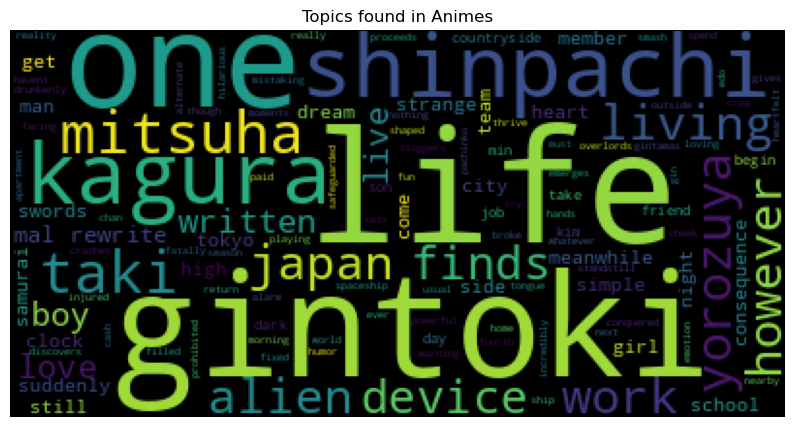

In [95]:
df_topic_0 = maldf_final[maldf_final['Dominant_Topic'] == 0]

text = df_topic_0['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")
plt.show()

### 2.7.2 Word Cloud for Topic 1: Anime about membership in a club or group

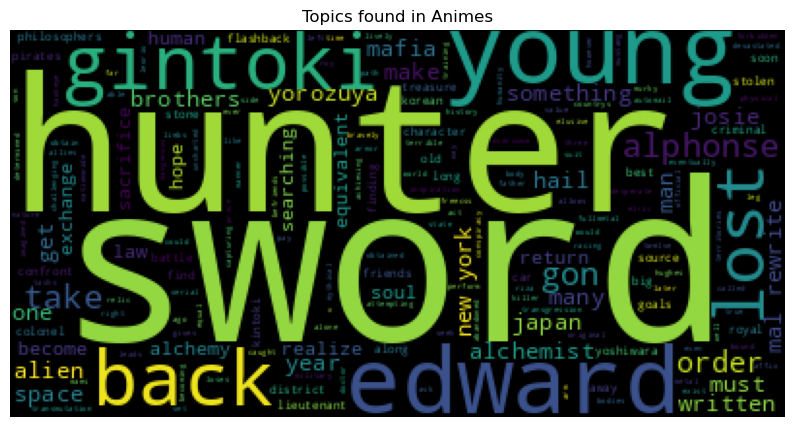

In [96]:
df_topic_1 = maldf_final[maldf_final['Dominant_Topic'] == 1]

text = df_topic_1['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")
plt.show()

### 2.7.3 Word Cloud for Topic 2: Anime about love story set in school

(-0.5, 399.5, 199.5, -0.5)

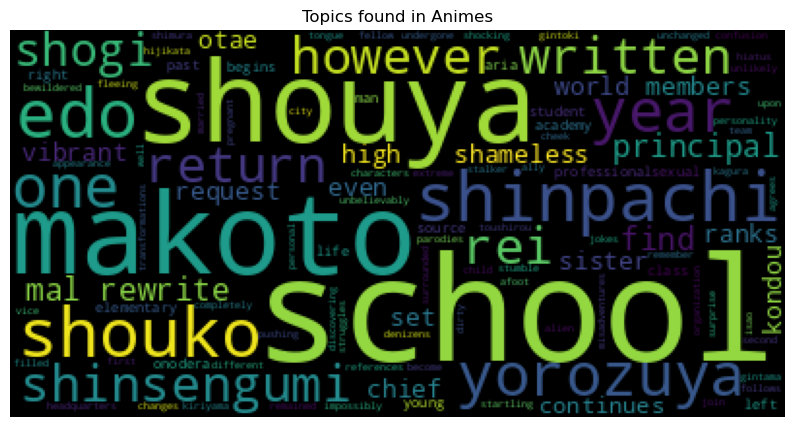

In [97]:
df_topic_2 = maldf_final[maldf_final['Dominant_Topic'] == 2]

text = df_topic_2['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")

### 2.7.4 Word Cloud for Topic 3: Anime featuring songs, films or videos

(-0.5, 399.5, 199.5, -0.5)

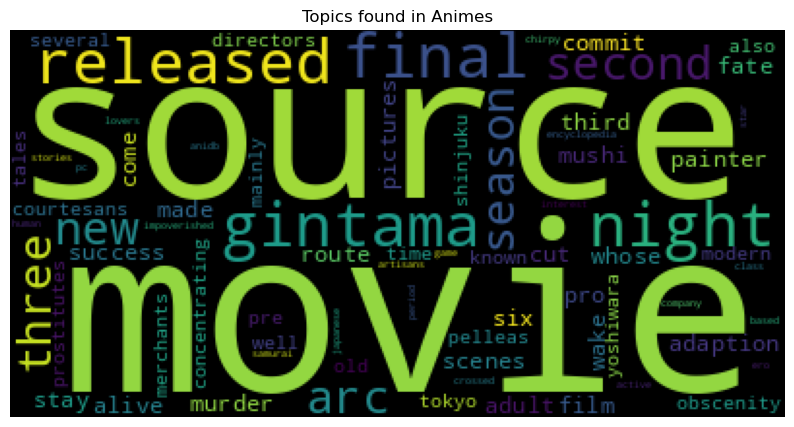

In [98]:
df_topic_3 = maldf_final[maldf_final['Dominant_Topic'] == 3]

text = df_topic_3['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")

### 2.7.5 Word Cloud for Topic 4: Anime about family life

(-0.5, 399.5, 199.5, -0.5)

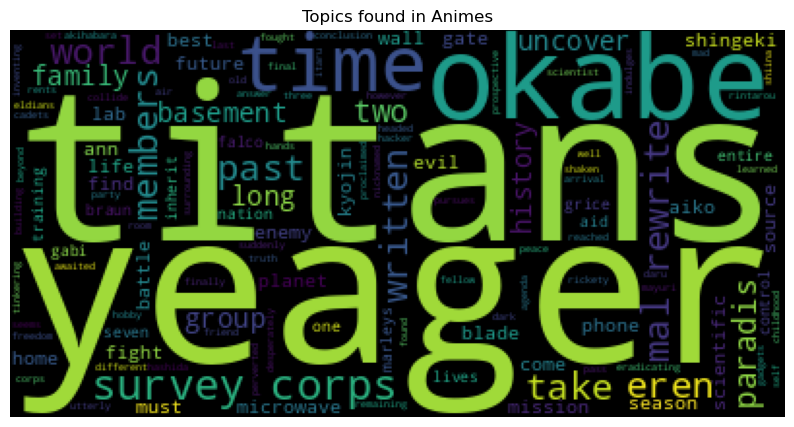

In [99]:
df_topic_4 = maldf_final[maldf_final['Dominant_Topic'] == 4]

text = df_topic_4['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")